In [11]:
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import dlc_practical_prologue as prologue
%matplotlib inline
N=1000
from torch.utils.data import DataLoader, Dataset
import tqdm
from torch.autograd import Variable


In [12]:
#train_input, train_target, train_classes, test_input, test_target, test_classes = prologue.generate_pair_sets(N)

In [13]:
# Chosen best architecture:
# 1. Weight Sharing
# 2. Without auxillary loss
# 3. Batch normalisation
# 4. Activation function: ReLU
# 5. Convolution layers for the base
print('Chosen best architecture has convolution layers for feature extraction, weight sharing, no auxillary loss with Batch normalization:CompareNet22')

class CompareNet1(nn.Module):
    def __init__(self):
        super(CompareNet1, self).__init__()
        self.base = nn.Sequential(nn.Linear(196,64),nn.ReLU(),nn.Linear(64,32))
        self.comparator = nn.Linear(64,2)
        self.classifier = nn.Linear(32,10) # for auxillary loss removal, remove this
        
    def forward(self, x):
        x_0 = x[:,0,:,:].flatten(1)
        x_1 = x[:,1,:,:].flatten(1)
        x_0 = F.relu(self.base(x_0)) 
        x_1 = F.relu(self.base(x_1))
        sign = F.relu(self.comparator(torch.cat([x_0,x_1],dim = 1)))
        digit_0 = F.relu(self.classifier(x_0))
        digit_1 = F.relu(self.classifier(x_1))
        return sign, digit_0, digit_1

class CompareNet11(nn.Module): #without weight sharing
    def __init__(self):
        super(CompareNet11, self).__init__()
        self.base = nn.Sequential(nn.Linear(392,196),nn.ReLU(),Linear(196,64),nn.ReLU()) 
        self.comparator = nn.Linear(64,2)
        self.classifier = nn.Linear(64,100) 
        
    def forward(self, x):
        x = x.view(-1,392)
        x = F.relu(self.base(x))
        sign = F.relu(self.comparator(x))
        num = F.relu(self.classifier(x))
        return sign, num

class CompareNet12(nn.Module): # without auxillary loss
    def __init__(self):
        super(CompareNet12, self).__init__()
        self.base = nn.Sequential(nn.Linear(196,64),nn.ReLU(),nn.Linear(64,32))
        self.comparator = nn.Linear(64,2)
        
    def forward(self, x):
        x_0 = x[:,0,:,:].flatten(1)
        x_1 = x[:,1,:,:].flatten(1)
        x_0 = F.relu(self.base(x_0)) 
        x_1 = F.relu(self.base(x_1))
        sign = F.relu(self.comparator(torch.cat([x_0,x_1],dim = 1)))
        return sign
    

        
class CompareNet2(nn.Module):
    def __init__(self,batch_normalization = False):
        super(CompareNet2, self).__init__()
        if batch_normalization: 
            self.base = nn.Sequential(nn.Conv2d(1, 32, kernel_size=3),nn.MaxPool2d(kernel_size=2),nn.BatchNorm2d(32),nn.Conv2d(32, 8, kernel_size=3),nn.MaxPool2d(kernel_size=2))
        else: 
            self.base = nn.Sequential(nn.Conv2d(1, 32, kernel_size=3),nn.MaxPool2d(kernel_size=2),nn.Conv2d(32, 8, kernel_size=3),nn.MaxPool2d(kernel_size=2))

            
        self.comparator = nn.Linear(64,2)
        self.classifier = nn.Linear(32,10)
    
    def forward(self, x):
        #x = x.flatten(1) # to remove weight sharing
        #x = F.relu(self.base(x))
        x_0 = x[:,:1,:,:]# for conv2d
        x_1 = x[:,1:2,:,:]# for conv2d
        x_0 = F.relu(self.base(x_0)) 
        x_1 = F.relu(self.base(x_1))
        x_0 = x_0.view(-1,32)
        x_1 = x_1.view(-1,32)
        sign = F.relu(self.comparator(torch.cat([x_0,x_1],dim = 1)))
        digit_0 = F.relu(self.classifier(x_0))
        digit_1 = F.relu(self.classifier(x_1))
        return sign, digit_0, digit_1
    
class CompareNet21(nn.Module): #without weight sharing
    def __init__(self,batch_normalization = False):
        super(CompareNet21, self).__init__()
        if batch_normalization:
            self.base = nn.Sequential(nn.Conv2d(2, 32, kernel_size=3),nn.MaxPool2d(kernel_size=2),nn.BatchNorm2d(32),nn.Conv2d(32, 16, kernel_size=3),nn.MaxPool2d(kernel_size=2))
        else:
            self.base = nn.Sequential(nn.Conv2d(2, 32, kernel_size=3),nn.MaxPool2d(kernel_size=2),nn.Conv2d(32, 16, kernel_size=3),nn.MaxPool2d(kernel_size=2))
        self.comparator = nn.Linear(64,2)
        self.classifier = nn.Linear(64,100) 
        
    def forward(self, x):
        x = F.relu(self.base(x))
        x = x.view(-1,64)
        sign = F.relu(self.comparator(x))
        num = F.relu(self.classifier(x))
        return sign, num

class CompareNet22(nn.Module): # without auxillary loss
    def __init__(self,batch_normalization = False):
        super(CompareNet22, self).__init__()
        if batch_normalization:
            self.base = nn.Sequential(nn.Conv2d(1, 32, kernel_size=3),nn.MaxPool2d(kernel_size=2),nn.BatchNorm2d(32),nn.Conv2d(32, 8, kernel_size=3),nn.MaxPool2d(kernel_size=2))
        else:
            self.base = nn.Sequential(nn.Conv2d(1, 32, kernel_size=3),nn.MaxPool2d(kernel_size=2),nn.Conv2d(32, 8, kernel_size=3),nn.MaxPool2d(kernel_size=2))

        self.comparator = nn.Linear(64,2)
        
    def forward(self, x):
        x_0 = x[:,:1,:,:]
        x_1 = x[:,1:2,:,:]
        x_0 = F.relu(self.base(x_0)) 
        x_1 = F.relu(self.base(x_1))
        x_0 = x_0.view(-1,32)
        x_1 = x_1.view(-1,32)
        sign = F.relu(self.comparator(torch.cat([x_0,x_1],dim = 1)))
        return sign

In [14]:
class DigitPairsDataset(Dataset):
    def __init__(self,img_pair,targets, classes):
        super(DigitPairsDataset, self).__init__()
        self.img_pair = img_pair
        self.targets = targets
        self.classes = classes
    
    def __len__(self):
        return self.targets.size()[0]
    
    def __getitem__(self, idx):
        return self.img_pair[idx], self.targets[idx], self.classes[idx]

This code generates runs the best chosen solution for 1 iteration. To increase the number of iterations, please change nb_iterations




  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

  2%|█▋                                                                                 | 1/50 [00:00<00:48,  1.01it/s]

  4%|███▎                                                                               | 2/50 [00:02<00:47,  1.00it/s]

  6%|████▉                                                                              | 3/50 [00:03<00:47,  1.01s/it]

  8%|██████▋                                                                            | 4/50 [00:04<00:48,  1.05s/it]

 10%|████████▎                                                                          | 5/50 [00:05<00:47,  1.07s/it]

 12%|█████████▉                                                                         | 6/50 [00:06<00:46,  1.05s/it]

 14%|███████████▌                                                                       | 7/50 [00:07<00:45,  1.06s/it]

 16%|█████████████▎           

Epoch : 9  ,   Train Accuracy : 91.00  , Validation Accuracy : 81.80 , Training Loss : 0.008580




 20%|████████████████▍                                                                 | 10/50 [00:10<00:42,  1.07s/it]

 22%|██████████████████                                                                | 11/50 [00:11<00:42,  1.08s/it]

 24%|███████████████████▋                                                              | 12/50 [00:12<00:41,  1.10s/it]

 26%|█████████████████████▎                                                            | 13/50 [00:14<00:42,  1.15s/it]

 28%|██████████████████████▉                                                           | 14/50 [00:15<00:42,  1.19s/it]

 30%|████████████████████████▌                                                         | 15/50 [00:16<00:41,  1.19s/it]

 32%|██████████████████████████▏                                                       | 16/50 [00:17<00:40,  1.20s/it]

 34%|███████████████████████████▉                                                      | 17/50 [00:19<00:42,  1.28s/it]

 36%|█████████████████████████

Epoch : 19  ,   Train Accuracy : 98.00  , Validation Accuracy : 81.30 , Training Loss : 0.004074




 40%|████████████████████████████████▊                                                 | 20/50 [00:23<00:41,  1.37s/it]

 42%|██████████████████████████████████▍                                               | 21/50 [00:25<00:40,  1.39s/it]

 44%|████████████████████████████████████                                              | 22/50 [00:26<00:39,  1.41s/it]

 46%|█████████████████████████████████████▋                                            | 23/50 [00:27<00:38,  1.44s/it]

 48%|███████████████████████████████████████▎                                          | 24/50 [00:29<00:37,  1.45s/it]

 50%|█████████████████████████████████████████                                         | 25/50 [00:31<00:37,  1.50s/it]

 52%|██████████████████████████████████████████▋                                       | 26/50 [00:32<00:34,  1.44s/it]

 54%|████████████████████████████████████████████▎                                     | 27/50 [00:33<00:32,  1.41s/it]

 56%|█████████████████████████

Epoch : 29  ,   Train Accuracy : 99.80  , Validation Accuracy : 82.20 , Training Loss : 0.001716




 60%|█████████████████████████████████████████████████▏                                | 30/50 [00:37<00:26,  1.35s/it]

 62%|██████████████████████████████████████████████████▊                               | 31/50 [00:39<00:25,  1.35s/it]

 64%|████████████████████████████████████████████████████▍                             | 32/50 [00:40<00:25,  1.42s/it]

 66%|██████████████████████████████████████████████████████                            | 33/50 [00:42<00:24,  1.46s/it]

 68%|███████████████████████████████████████████████████████▊                          | 34/50 [00:43<00:22,  1.41s/it]

 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [00:44<00:20,  1.40s/it]

 72%|███████████████████████████████████████████████████████████                       | 36/50 [00:46<00:19,  1.39s/it]

 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [00:47<00:17,  1.36s/it]

 76%|█████████████████████████

Epoch : 39  ,   Train Accuracy : 99.90  , Validation Accuracy : 81.50 , Training Loss : 0.000695




 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [00:51<00:13,  1.35s/it]

 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [00:52<00:12,  1.36s/it]

 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [00:54<00:11,  1.42s/it]

 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [00:56<00:10,  1.52s/it]

 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [00:57<00:08,  1.49s/it]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [00:59<00:07,  1.55s/it]

 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [01:00<00:06,  1.53s/it]

 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [01:02<00:04,  1.49s/it]

 96%|█████████████████████████

Epoch : 49  ,   Train Accuracy : 99.90  , Validation Accuracy : 80.80 , Training Loss : 0.000376




100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [01:06<00:00,  1.32s/it]


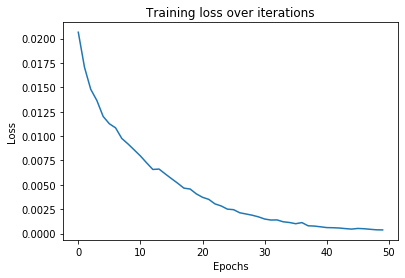

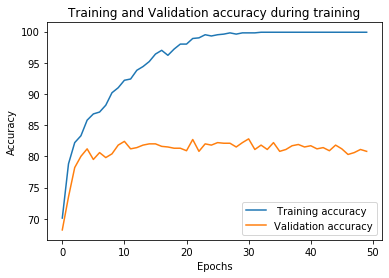

In [18]:
criterion = nn.CrossEntropyLoss()
auxillary = False # choose to have auxillary loss or not
linear = False # choose to have linear layers or not for base
wt_sharing =  True #choose to have weight sharing or not
conv = True # choose to have convolution layers for base or not
batch_normalization = True # choose to have batch normalisation for base or not

if not wt_sharing and not auxillary:
    print('Please enable one of weight sharing or auxillary')

if batch_normalization and linear:
    print('Batch normalization is only applied with convolution layers')

    
# chosing net based on user input
if linear and auxillary and wt_sharing:
    net = CompareNet1()
    flag = 1
elif linear and auxillary and not wt_sharing:
    net = CompareNet11()
    flag = 11
elif linear and not auxillary and wt_sharing:
    net = CompareNet12()
    flag = 12
elif conv and auxillary and wt_sharing:
    net = CompareNet2(batch_normalization = batch_normalization)
    flag = 2
elif conv and auxillary and not wt_sharing:
    net = CompareNet21(batch_normalization = batch_normalization)
    flag = 21
elif conv and not auxillary and wt_sharing:
    net = CompareNet22(batch_normalization = batch_normalization)
    flag = 22   
    
nb_iterations = 1
count = 0
epochs = 50
print('This code generates runs the best chosen solution for {nb_iterations} iteration. To increase the number of iterations, please change nb_iterations'.format(nb_iterations=nb_iterations))
mu = 1.0 # parameter to control weightage given to auxillary loss
optimizer = optim.Adam(net.parameters(),lr = 0.001)


# function to calculate accuracy

def calc_accuracy(data_loader,model):
    correct_count = 0.0
    for i, data in enumerate(data_loader,0):
        img_pair, target, classes = data
        if auxillary and wt_sharing:
            pred_sign, pred_class0, pred_class1 = net(img_pair)
            loss = criterion(pred_sign,target)+ mu*(criterion(pred_class0, classes[:,0])+ criterion(pred_class1, classes[:,1]))
        elif auxillary and not wt_sharing:
            pred_sign, pred_class = net(img_pair) # to remove weight sharing
            classes = 10*classes[:,1]+classes[:,0]
            loss = criterion(pred_sign,target)+ mu*criterion(pred_class, classes)
        elif not auxillary and wt_sharing:
            pred_sign = net(img_pair)# for removing weight sharing
            loss = criterion(pred_sign,target)
        pred = torch.argmax(pred_sign,-1)
        correct_count += int((target.eq(pred)).sum())
    return correct_count*100.0/N


while count<nb_iterations:
    loss_arr = []
    train_acc_arr = []
    val_acc_arr = []
    train_input, train_target, train_classes, test_input, test_target, test_classes = prologue.generate_pair_sets(N)
    train_dataset = DigitPairsDataset(train_input,train_target,train_classes)
    test_dataset = DigitPairsDataset(test_input,test_target,test_classes)
    train_loader = DataLoader(train_dataset,batch_size=32, shuffle = True, num_workers = 0)
    test_loader = DataLoader(test_dataset,batch_size=32, shuffle = True, num_workers = 0)
    for epoch in tqdm.tqdm(range(epochs)):
        net.train()
        running_loss = 0.0

        for i, data in enumerate(train_loader,0):
            img_pair, target, classes = data

            optimizer.zero_grad()

            if auxillary and wt_sharing:
                pred_sign, pred_class0, pred_class1 = net(img_pair)
                loss = criterion(pred_sign,target)+ mu*(criterion(pred_class0, classes[:,0])+ criterion(pred_class1, classes[:,1]))

            elif auxillary and not wt_sharing:
                pred_sign, pred_class = net(img_pair) 
                classes = 10*classes[:,1]+classes[:,0]
                loss = criterion(pred_sign,target)+ mu*criterion(pred_class, classes)

            elif not auxillary and wt_sharing:
                pred_sign = net(img_pair)
                loss = criterion(pred_sign,target)

            running_loss += loss.item()
            loss.backward()
            optimizer.step()
        net.eval()
        running_loss /= N
        loss_arr.append(running_loss)
        train_acc = calc_accuracy(train_loader,net)
        val_acc = calc_accuracy(test_loader,net)
        train_acc_arr.append(train_acc)
        val_acc_arr.append(val_acc)
        if epoch % 10 == 9:
            print("Epoch : %d  ,   Train Accuracy : %.2f  , Validation Accuracy : %.2f , Training Loss : %.6f" %(epoch, train_acc, val_acc, running_loss))

    # plotting loss curve
    plt.plot(range(epochs),loss_arr)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training loss over iterations")
    fileplot1 = "plot_loss_{count}.png".format(count=count)
    plt.savefig(fileplot1)
    plt.show()

    # plotting accuracy curves
    plt.plot(range(epochs),train_acc_arr, label  =" Training accuracy")
    plt.plot(range(epochs), val_acc_arr, label ="Validation accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epochs")
    plt.title("Training and Validation accuracy during training")
    plt.legend()
    fileplot = "plot_acc_{count}.png".format(count=count)
    plt.savefig(fileplot)
    plt.show()



    fileloss = "loss_{count}.npy".format(count=count)
    np.save(fileloss,loss_arr)
    filetrain = "train_acc_{count}.npy".format(count=count)
    np.save(filetrain,train_acc_arr)
    fileval = "val_acc_{count}.npy".format(count=count)
    np.save(fileval,val_acc_arr)
    count+= 1
    